In [1]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from utils.elpv_reader import load_dataset

Step1:  Load the dataset

In [7]:
# Respectively: image, reflection probability, type. Our classifier needs to classify based on reflection probability
images, proba, types = load_dataset()
print(f"The size of the data set is: {images.shape[0]}")
print(f"The size of the image is: {images.shape[1]} * {images.shape[2]}")
print(proba)
print(types)

The size of the data set is: 2624
The size of the image is: 300 * 300
[1. 1. 1. ... 0. 0. 0.]
['mono' 'mono' 'mono' ... 'poly' 'poly' 'poly']


Step2: Convert each image to the pixel histogram

In [8]:
image_his = []

for image in images:
    hist = cv2.calcHist([image], [0], None, [256], [0.0, 255.0])
    image_his.append(hist.flatten())

# normalization
scaler = MinMaxScaler()
image_his = scaler.fit_transform(image_his)

(2624, 256)


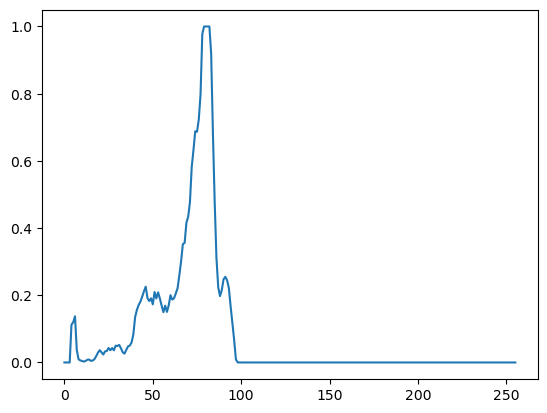

In [9]:
print(image_his.shape)
plt.plot(image_his[0])
plt.show()

Step3: Split the dataset into train set and test set

In [13]:
# split the dataset into train set and test set
x_train, x_test, y_train, y_test = train_test_split(image_his, proba, test_size=0.25, stratify=proba, random_state=42)

Step4: Use the SVM classifier to process the dataset

In [44]:
# kernel options: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
# when doing classifier, y_train is a vector of integers or strings
svm_classifier = SVC(C=10, gamma=0.1, kernel="rbf").fit(x_train, y_train.astype("str"))
predict_labels = svm_classifier.predict(x_test)

Step5: Report the performance of SVM

In [45]:
print(metrics.classification_report(y_test.astype("str"), predict_labels))

                    precision    recall  f1-score   support

               0.0       0.67      0.94      0.78       377
0.3333333333333333       0.00      0.00      0.00        74
0.6666666666666666       0.00      0.00      0.00        26
               1.0       0.74      0.50      0.60       179

          accuracy                           0.68       656
         macro avg       0.35      0.36      0.35       656
      weighted avg       0.59      0.68      0.61       656


D:\anaconda3\envs\comp9517\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\comp9517\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\comp9517\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
x_shape=[]		#按照保存特征比例进行 PCA 降维之后，数据的维度保存在这个列表中
scores = []		#每次降维后的数据的评分保存在这里面

#feature_number = np.linspace(start=1, stop=image_his.shape[1], num=30, dtype=int)
#print(feature_number)

for number in range(1, image_his.shape[1] + 1):
    print(f"After the PCA, the feature number is: {number}")
    pca = PCA(n_components=number, copy=True)
    images_pca = pca.fit_transform(image_his)

    x_train, x_test, y_train, y_test = train_test_split(images_pca, proba, test_size=0.25, stratify=proba, random_state=42)

    svc_classifier = SVC(C=100, kernel="rbf").fit(x_train, y_train.astype("str"))

    score = svc_classifier.score(x_test, y_test.astype("str"))

    x_shape.append(images_pca.shape[1])

    scores.append(score)

After the PCA, the feature number is: 1
After the PCA, the feature number is: 2
After the PCA, the feature number is: 3
After the PCA, the feature number is: 4
After the PCA, the feature number is: 5
After the PCA, the feature number is: 6
After the PCA, the feature number is: 7
After the PCA, the feature number is: 8
After the PCA, the feature number is: 9
After the PCA, the feature number is: 10
After the PCA, the feature number is: 11
After the PCA, the feature number is: 12
After the PCA, the feature number is: 13
After the PCA, the feature number is: 14
After the PCA, the feature number is: 15
After the PCA, the feature number is: 16
After the PCA, the feature number is: 17
After the PCA, the feature number is: 18
After the PCA, the feature number is: 19
After the PCA, the feature number is: 20
After the PCA, the feature number is: 21
After the PCA, the feature number is: 22
After the PCA, the feature number is: 23
After the PCA, the feature number is: 24
After the PCA, the featur

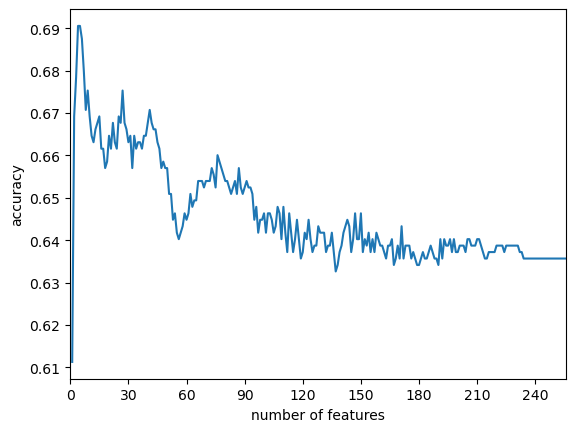

The max score is: 0.6905487804878049
When the feature number is: 4, we can get the max score


In [30]:
plt.plot(x_shape, scores)
plt.xlabel('number of features')
plt.ylabel('accuracy')
x_major_locator = plt.MultipleLocator(30)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlim(0, 256)
plt.show()
max_scores = max(scores)
print(f"The max score is: {max(scores)}")
index = scores.index(max_scores)
feature_number = x_shape[index]
print(f"When the feature number is: {feature_number}, we can get the max score")

In [ ]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('svm', SVC())
])

param_grid = [{
    'pca__n_components': range(1, image_his.shape[1] + 1),
    'svm__C': [0.01, 0.1, 1, 10, 100, 1000],
    'svm__kernel': ['linear']
},
{
    'pca__n_components': range(1, image_his.shape[1] + 1),
    'svm__C': [0.01, 0.1, 1, 10, 100, 1000],
    'svm__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'svm__kernel': ['linear']
}]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train.astype("str"))

In [ ]:
best_n_components = grid_search.best_estimator_.named_steps['pca'].n_components
best_score = grid_search.best_score_
print(f"Best number of PCA components is: {best_n_components}")
print(f"Best cross-validation accuracy is: {best_score}")

best_model = grid_search.best_estimator_
predict_labels = best_model.predict(x_test)

print(metrics.classification_report(y_test.astype("str"), predict_labels))

# Test

In [300]:
from sklearn.metrics import confusion_matrix
import pandas as pd

### 1. Calculate the confusion matrix for all test images

In [301]:
# Calculate the confusion matrix for all test images
confusion_all = confusion_matrix(y_test.astype("str"), predict_labels)
# print(confusion_all)
confusion_all = np.array(confusion_all)

# Class label
class_labels = ["0.0", "0.3333", "0.6666", "1.0"]

# Print confusion matrix
print("Confusion Matrix (All Test Images):")
print("\t" + "\t".join(class_labels))
for i in range(len(class_labels)):
    print(class_labels[i] + "\t", end="")
    for j in range(len(class_labels)):
        print(confusion_all[i][j], end="\t")
    print()

# Calculate accuracy, recall and F1 scores
for i in range(len(class_labels)):
    tp = confusion_all[i][i]
    fp = sum(confusion_all[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_all[i][j] for j in range(len(class_labels)) if j != i)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    print(f"\nClass {class_labels[i]}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")


Confusion Matrix (All Test Images):
	0.0	0.3333	0.6666	1.0
0.0	339	5	4	29	
0.3333	61	1	0	12	
0.6666	25	0	0	1	
1.0	99	1	2	77	

Class 0.0:
Precision: 0.62
Recall: 0.36
F1 Score: 0.45

Class 0.3333:
Precision: 0.62
Recall: 0.36
F1 Score: 0.45

Class 0.6666:
Precision: 0.62
Recall: 0.36
F1 Score: 0.45

Class 1.0:
Precision: 0.62
Recall: 0.36
F1 Score: 0.45


### 2.Calculate the confusion matrix for monocrystalline

In [302]:
print("y_test size:", y_test.shape)
print("predict_labels size:", predict_labels.shape)

y_test size: (656,)
predict_labels size: (656,)


In [303]:
# monocrystalline_indices range of index values
y_test = y_test.astype("str")
monocrystalline_indices = np.where(types == 'mono')
print("Monocrystalline Indices Range:", min(monocrystalline_indices[0]), "to", max(monocrystalline_indices[0]))

Monocrystalline Indices Range: 0 to 2443


In [304]:
# Prints the unique value of the types array
unique_types = np.unique(types)
print(unique_types)


['mono' 'poly']


In [305]:
# calculate monocrystalline_indices
monocrystalline_indices = np.where(types == 'mono')[0]  # Extract the index array with [0]

# Create a y_test_mono array that contains only the real labels for images of type "monocrystalline"
y_test_mono = y_test[monocrystalline_indices[monocrystalline_indices < len(y_test)]]

# Creates the predict_labels_mono array that contains only prediction labels for images of type "monocrystalline"
predict_labels_mono = predict_labels[monocrystalline_indices[monocrystalline_indices < len(y_test)]]


In [306]:
# Check that the sample in the types array matches the label in the corresponding position in y_test
mismatched_indices = np.where(types != y_test)[0]
print("Indices with mismatched labels:", mismatched_indices)


Indices with mismatched labels: [0]


/var/folders/2f/yj4193f95b58g8d0ymcxp11w0000gn/T/ipykernel_1719/3185375691.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mismatched_indices = np.where(types != y_test)[0]


In [307]:
print(f"Sample at index 0 - 'types' label: {types[0]}, 'y_test' label: {y_test[0]}")

Sample at index 0 - 'types' label: mono, 'y_test' label: 0.6666666666666666


In [308]:
# Computational confusion matrix
confusion_matrix = confusion_matrix(y_test_mono, predict_labels_mono)

# Creates row and column labels for the confusion matrix
class_labels = ['0.0', '0.3333333333333333', '0.6666666666666666', '1.0']

# Create a data box with an explained confusion matrix
confusion_mono = pd.DataFrame(confusion_matrix, index=class_labels, columns=class_labels)

print("Confusion Matrix (mono):")
print(confusion_mono)

# Calculate accuracy, recall and F1 scores
for i in range(len(class_labels)):
    tp = confusion_matrix[i][i]
    fp = sum(confusion_matrix[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_matrix[i][j] for j in range(len(class_labels)) if j != i)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    print(f"\nClass {class_labels[i]}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")


Confusion Matrix (mono):
                    0.0  0.3333333333333333  0.6666666666666666  1.0
0.0                 118                   3                   0   11
0.3333333333333333   26                   0                   0    3
0.6666666666666666   11                   0                   0    1
1.0                  41                   1                   1   24

Class 0.0:
Precision: 0.60
Recall: 0.89
F1 Score: 0.72

Class 0.3333333333333333:
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class 0.6666666666666666:
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class 1.0:
Precision: 0.62
Recall: 0.36
F1 Score: 0.45


### 3.Calculate the confusion matrix for polycrystalline

In [323]:
from sklearn.metrics import confusion_matrix

In [324]:
# Check that the types array contains labels of type 'poly'
contains_poly = 'poly' in types

if contains_poly:
    print("The types array contains labels of type 'poly'")
else:
    print("The types array does not contain labels of type 'poly'")

The types array contains labels of type 'poly'


In [326]:
print("y_test size:", y_test.shape)

# predict_labels size
predict_labels = svm_classifier.predict(his_test)
print("predict_labels size:", predict_labels.shape)

y_test size: (656,)
predict_labels size: (656,)


In [327]:
polycrystalline_indices = np.where(types == 'poly')[0]
print(polycrystalline_indices)

[  60   61   62 ... 2621 2622 2623]


In [328]:
y_test_poly = y_test[polycrystalline_indices[polycrystalline_indices < len(y_test)]]
predict_labels_poly = predict_labels[polycrystalline_indices[polycrystalline_indices < len(y_test)]]

# The confusion matrix of polycrystalline hybrid samples is calculated
confusion_poly = confusion_matrix(y_test_poly, predict_labels_poly)

# Creates row and column labels for the confusion matrix
class_labels = ['0.0', '0.3333333333333333', '0.6666666666666666', '1.0']

# Create a data box to display the confusion matrix
confusion_poly_df = pd.DataFrame(confusion_poly, index=class_labels, columns=class_labels)

# Print confusion matrix
print("Confusion Matrix (poly):")
print(confusion_poly_df)


# Calculate and output the Precision, Recall, and F1 Score for each category
for i in range(len(class_labels)):
    tp = confusion_poly[i][i]
    fp = sum(confusion_poly[j][i] for j in range(len(class_labels)) if j != i)
    fn = sum(confusion_poly[i][j] for j in range(len(class_labels)) if j != i)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    print(f"\nClass {class_labels[i]}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")


Confusion Matrix (poly):
                    0.0  0.3333333333333333  0.6666666666666666  1.0
0.0                 221                   2                   4   18
0.3333333333333333   35                   1                   0    9
0.6666666666666666   14                   0                   0    0
1.0                  58                   0                   1   53

Class 0.0:
Precision: 0.67
Recall: 0.90
F1 Score: 0.77

Class 0.3333333333333333:
Precision: 0.33
Recall: 0.02
F1 Score: 0.04

Class 0.6666666666666666:
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Class 1.0:
Precision: 0.66
Recall: 0.47
F1 Score: 0.55
